In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime

In [2]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css));

## Importing Data

In [3]:
# set up dict of dtypes
dtypes = {
        'CASE_REPORT_NO' : object,
        'OFFENSE' : str,
        'ORC' : str,
        'OFFENSE_NO' : np.float64,
        'OCCURRED_ON' : object,
        'REPORTED_ON' : object,
        'BLOCK_BEGIN' : np.float64,
        'BLOCK_END' : np.float64,
        'STREET_NAME' : str,
        'CITY' : object,
        'ADDRESS_STATE' : object,
        'DISTRICT' : object,
        'BEAT' : object,
        'REPORTING_AREA' : object,
        'NEIGHBORHOOD' : str,
        'DATATYPE_ID' : object, 
        'REPORTED_BY_OFFICER' : object,
        'REPORTED_BY_OFFICER_BADGE_NO' : object,
        'UCR' : object,
        'THEFT_CODE' : object
        }

In [4]:
# read in raw data
df = pd.read_csv(r'data/Crime_Incidents.csv', header=0, dtype=dtypes, parse_dates=['OCCURRED_ON'])

## Getting rid of unwanted data

In [5]:
# drop all unwanted columns from raw data
to_drop = ['CASE_REPORT_NO', 'OFFENSE_NO', 'CITY', 'ADDRESS_STATE', 'DISTRICT', 'BEAT', 'REPORTING_AREA', 'DATATYPE_ID',
                'REPORTED_BY_OFFICER', 'REPORTED_BY_OFFICER_BADGE_NO', 'UCR', 'THEFT_CODE', 'REPORTED_ON']
df = df.drop(labels=to_drop, axis=1)

In [6]:
# rename all remaining columns
new_cols = [ 
        'offense', 'orc', 'date', 'block_begin', 'block_end', 'street_name', 'neighborhood' 
        ]

df.columns = new_cols

## Cleaning up the remaining data

In [7]:
# check crimes per year, output suggests delete all data before 2010
df.groupby(df.date.dt.year).size()

date
1991.0        6
1992.0        1
1993.0        2
1994.0        2
1995.0        2
1996.0        3
1997.0        3
1998.0        5
1999.0        6
2000.0       16
2001.0       11
2002.0       14
2003.0       19
2004.0       18
2005.0       32
2006.0       47
2007.0       63
2008.0       90
2009.0      174
2010.0    21090
2011.0    38094
2012.0    35917
2013.0    32843
2014.0    31013
2015.0    31643
2016.0    30354
2017.0    25580
dtype: int64

In [8]:
# let's take a closer look at 2010, as the total appears to be a bit low...
df[df.date.dt.year == 2010].groupby(df.date.dt.month).size()
# so data isn't reliable until July, 2010

date
1.0       81
2.0       14
3.0       35
4.0       37
5.0       68
6.0      265
7.0     3855
8.0     3716
9.0     3491
10.0    3516
11.0    3178
12.0    2834
dtype: int64

In [9]:
# set limit at July 1, 2010, and delete data prior to the limit
limit = datetime.date(2010, 7 , 1)
df = df[df.date.dt.date >= limit]

In [10]:
# that looks better!
df[df.date.dt.year == 2010].groupby(df.date.dt.month).size()

date
7     3855
8     3716
9     3491
10    3516
11    3178
12    2834
dtype: int64

In [11]:
# for some reason, street_name was dtype = object, and had some floats, so convert all to strings
df.street_name = df.street_name.apply(str)

In [12]:
# let's make all text columns lowercase (street name isn't working)
lower_cols = ['offense', 'orc', 'street_name', 'neighborhood']
df[lower_cols] = df[lower_cols].applymap(str.lower)

In [13]:
# add columns for year and month to make analyzing crimes over time easier later
df = df.assign(month=df.date.dt.strftime('%m'))
df = df.assign(year=df.date.dt.strftime('%Y'))

## Creating geospatial data

When I first attempted to set addresses, I ran into errors with (surprise!) null values. Let's take a closer look at those first.

In [14]:
# upon closer look, 502 entires have a 'block_begin', 'block_end', and 'street_name' of null
# let's look at one
df.loc[81]

# telecommunications harassment? this won't be useful for any analysis involving location

offense                        telecommunications harassment
orc             2917-21 (90z) -telecommunications harassment
date                                     2012-08-28 12:00:00
block_begin                                              NaN
block_end                                                NaN
street_name                                              nan
neighborhood                                        millvale
month                                                     08
year                                                    2012
Name: 81, dtype: object

In [15]:
# I'm going to move them to their own smaller dataframes to inspect further
block_begin_null = df[df.block_begin.isnull()]
block_end_null = df[df.block_begin.isnull()]
street_name_null = df[df.street_name == 'nan']

In [16]:
# let's compare
block_begin_null.equals(block_end_null)

True

In [17]:
block_end_null.equals(street_name_null)

True

In [18]:
# so these 502 entries are all the same and can be removed
df = df[df.block_begin.notnull()]

In [19]:
# we should now be able to create a new column with the entire address
# first, since the addresses are given only to a block, I decided to make each crime "happen" at the middle of the block
df2 = df.assign(block_avg=(np.int32(np.ceil((df.block_begin + df.block_end) / 2))))

# convert to string
df2.block_avg = df2.block_avg.apply(str)

In [20]:
# now, create the address!
df2['address'] = df2.block_avg + ' ' + df2.street_name + ', cincinnati, oh'

In [21]:
# it works!
df2.head()

,offense,orc,date,block_begin,block_end,street_name,neighborhood,month,year,block_avg,address
0,theft -(from motor vehicle),2913-02 (23f) -theft -(from motor vehicle),2014-02-22 00:01:00,100.0,199.0,e court st,c. b. d. / riverfront,02,2014,150,"150 e court st, cincinnati, oh"
1,felonious assault -(aggravated assault),2903-11 (13a) -felonious assault -(aggravated ...,2011-08-05 12:30:00,900.0,999.0,ezzard charles dr,west end,08,2011,950,"950 ezzard charles dr, cincinnati, oh"
2,criminal damaging/endangering,2909-06 (290) -criminal damaging/endangering,2016-06-08 10:00:00,2100.0,2199.0,weron ln,east westwood,06,2016,2150,"2150 weron ln, cincinnati, oh"
3,assault -(simple assault),2903-13 (13b) -assault -(simple assault),2015-05-15 16:25:00,1600.0,1699.0,ross av,east price hill,05,2015,1650,"1650 ross av, cincinnati, oh"
4,breaking and entering,2911-13 (220) -breaking and entering,2012-06-17 06:00:00,800.0,899.0,hutchins av,avondale,06,2012,850,"850 hutchins av, cincinnati, oh"


In [22]:
# next, it would be helpful to convert addresses to a set of cordinates
# edit: maybe not necessary, google fusion tables is parsing current address format fine

In [23]:
# write out final dataframe to csv file for analysis!
df2.to_csv('data/final_crime_data.csv')

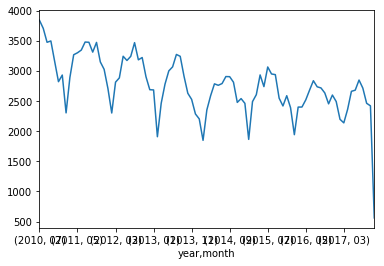

In [24]:
#we can now visualize for the first time the data
df.groupby(['year','month']).size().plot()

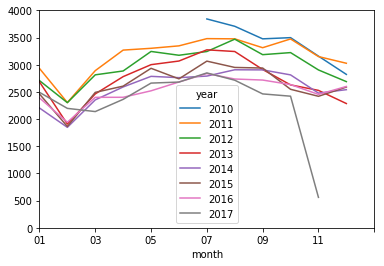

In [25]:
#let's see if we can graph each year as a seprate line
#months = ['January', 'February', 'March', 'April', 'May', 'June', 
    #'July', 'August', 'September', 'October', 'November', 'December']
df2 = df.groupby(['year', 'month']).size()
df2.unstack(0).plot(xlim=[0,12], ylim=[0,4000])